## Developing "Momentum" Trading Strategy

This code is based on the algorithm discussed by @MattMacarty on YouTube

url : https://www.youtube.com/watch?v=fqltiq5EahU

//an important takeaway at the end

In [1]:
#importing dependencies

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# fetchng data using Alpha Vantage
API_KEY = '[API_key]'
symbol = 'GLD'

start_date = dt.datetime.now() - dt.timedelta(days=5*365)

gld = pdr.av.time_series.AVTimeSeriesReader(symbol, api_key=API_KEY, start=start_date).read()
gld.head()

,open,high,low,close,volume
2019-02-19,125.98,126.79,125.93,126.70,15614028
2019-02-20,127.00,127.21,126.31,126.48,8889665
2019-02-21,126.15,126.22,125.05,125.05,8634596
2019-02-22,125.53,125.95,125.39,125.50,5439375
2019-02-25,125.78,125.90,125.23,125.37,4882615


In [3]:
# creating the timeframe
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['volume'])
gld = gld[['day', 'open', 'high', 'low', 'close']]
gld.head()

,day,open,high,low,close
2019-02-19,1,125.98,126.79,125.93,126.70
2019-02-20,2,127.00,127.21,126.31,126.48
2019-02-21,3,126.15,126.22,125.05,125.05
2019-02-22,4,125.53,125.95,125.39,125.50
2019-02-25,5,125.78,125.90,125.23,125.37


We need a signal, which in this case will be a moving average, to create buy/sell trigger. There will be two moving averages, a slow and a fast one. When the fast one crosses the slow one, we get into the trade and we're going to exit/go short when the fast crosses below the slow one. For this strategy, we're always in the a trade, either long or short.

In [4]:
# adding moving averages to the data frame***

gld['9-day'] = gld['close'].rolling(9).mean()
gld['21-day'] = gld['close'].rolling(21).mean()
gld[19:25]

,day,open,high,low,close,9-day,21-day
2019-03-18,20,123.30,123.3998,122.8900,123.04,122.604444,NaN
2019-03-19,21,123.72,123.7900,123.3400,123.38,122.801111,123.587619
2019-03-20,22,123.66,124.4200,122.6500,124.18,123.097778,123.467619
2019-03-21,23,124.36,124.3700,123.1100,123.68,123.191111,123.334286
2019-03-22,24,123.93,124.2200,123.7300,123.97,123.383333,123.282857
2019-03-25,25,124.56,125.1100,124.4801,124.92,123.598889,123.255238


Now there is a slight error when visualising the data like this, because it includes the closing price of the day on the same day, as if we have look-ahead information. So, to calculate the moving average on 21 days, I need to wait for the 21st day to end to get the closing price. So, the .shift() moves it ahead by a day and corrects the data logically.

In [5]:
# after correction

gld['9-day'] = gld['close'].rolling(9).mean().shift()
gld['21-day'] = gld['close'].rolling(21).mean().shift()
gld[19:25]

,day,open,high,low,close,9-day,21-day
2019-03-18,20,123.30,123.3998,122.8900,123.04,122.457778,NaN
2019-03-19,21,123.72,123.7900,123.3400,123.38,122.604444,NaN
2019-03-20,22,123.66,124.4200,122.6500,124.18,122.801111,123.587619
2019-03-21,23,124.36,124.3700,123.1100,123.68,123.097778,123.467619
2019-03-22,24,123.93,124.2200,123.7300,123.97,123.191111,123.334286
2019-03-25,25,124.56,125.1100,124.4801,124.92,123.383333,123.282857


In [6]:
# adding "signal" column

gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)              #buy signal
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal']) #sell signal
gld.dropna(inplace=True)
gld.head()

,day,open,high,low,close,9-day,21-day,signal
2019-03-20,22,123.66,124.42,122.6500,124.18,122.801111,123.587619,-1
2019-03-21,23,124.36,124.37,123.1100,123.68,123.097778,123.467619,-1
2019-03-22,24,123.93,124.22,123.7300,123.97,123.191111,123.334286,-1
2019-03-25,25,124.56,125.11,124.4801,124.92,123.383333,123.282857,1
2019-03-26,26,124.48,124.51,124.0700,124.30,123.598889,123.255238,1


In [7]:
# calculate instantaneous returns/system returns

gld['return'] = np.log(gld['close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,day,open,high,low,close,9-day,21-day,signal,return,system_return,entry
2019-03-20,22,123.66,124.42,122.6500,124.18,122.801111,123.587619,-1,NaN,NaN,NaN
2019-03-21,23,124.36,124.37,123.1100,123.68,123.097778,123.467619,-1,-0.004035,0.004035,0.0
2019-03-22,24,123.93,124.22,123.7300,123.97,123.191111,123.334286,-1,0.002342,-0.002342,0.0
2019-03-25,25,124.56,125.11,124.4801,124.92,123.383333,123.282857,1,0.007634,0.007634,2.0
2019-03-26,26,124.48,124.51,124.0700,124.30,123.598889,123.255238,1,-0.004976,-0.004976,0.0


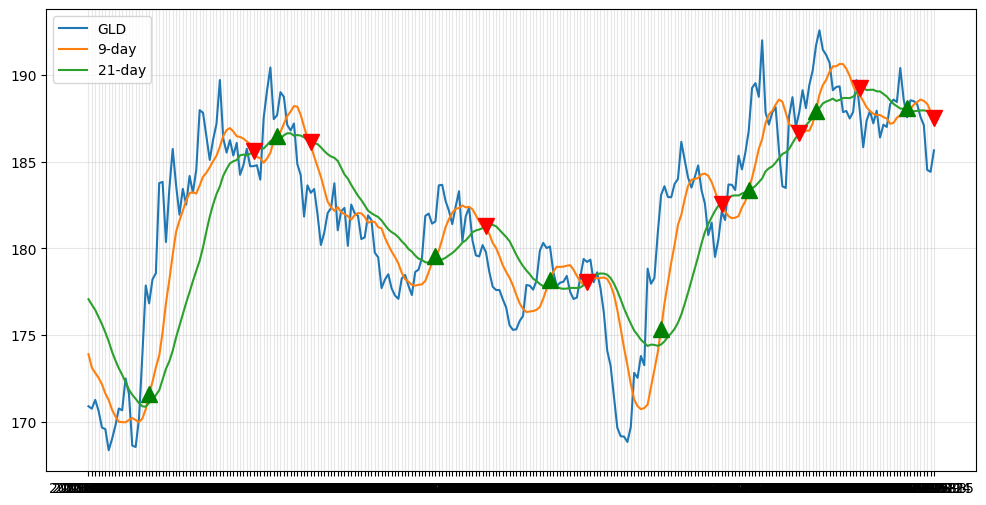

In [8]:
# plot trade on time series

plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['close'], label='GLD')
plt.plot(gld.iloc[-252:]['9-day'], label='9-day')
plt.plot(gld.iloc[-252:]['21-day'], label='21-day')
plt.plot(gld.iloc[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^', color = 'g', markersize = 12)
plt.plot(gld.iloc[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v', color = 'r', markersize = 12)
plt.legend(loc=2)

Now, we want to see how this strategy performs against buy and hold over 5 years.

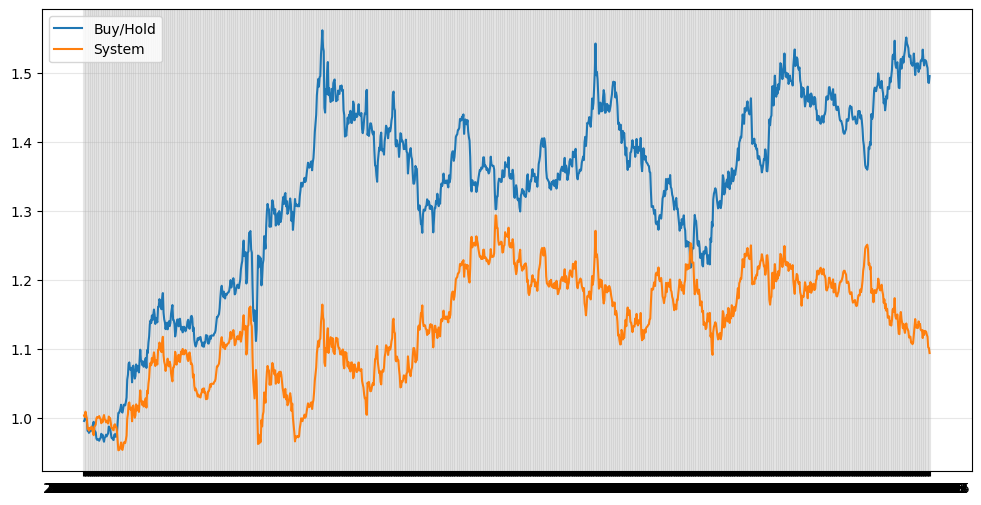

In [9]:
plt.plot(np.exp(gld['return']).cumprod(), label = 'Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label = 'System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

Ok, this doesn't work. Lol

In [10]:
# checking returns after all the years

buy_hold_return = np.exp(gld['return']).cumprod() - 1
print(buy_hold_return.iloc[-1])

0.49508777580930996


In [11]:
system_return = np.exp(gld['system_return']).cumprod() - 1
print(system_return.iloc[-1])

0.09424680851320333


### Important Observation

Remember when we shifted the close prices by a day? Try rerunning the whole thing without the shift. We notice the system performs better than the buy/hold strategy, which is false and misleading.